**CLASSIFICATION OF BRAIN MRI TUMOR IMAGES**

dataset source: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection



In [35]:
import numpy as np 
import pandas as pd
import torchvision.models as models
import glob
from PIL import Image
import torch
from sklearn.manifold import TSNE
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
torch.backends.cudnn.deterministic = True
import os
print(os.listdir())

['.config', 'brain.zip', 'working', 'sample_data']


In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
import zipfile
with zipfile.ZipFile('brain.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('working')

In [38]:
print('After zip extraction:')
print(os.listdir("working/"))

After zip extraction:
['brain']


In [39]:
data_root = '/content/working/brain'
print(os.listdir(data_root))

['test', 'train']


In [40]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['yes', 'no']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 98/98 [00:00<00:00, 5952.12it/s]


In [41]:
!ls train

no  yes


In [42]:
import torchvision

In [65]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                                   
    transforms.Grayscale(num_output_channels=3),
    

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                                 
    
    transforms.Grayscale(num_output_channels=3),
   
   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 7
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [66]:
len(train_dataloader), len(train_dataset)

(30, 210)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


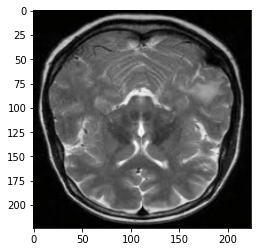

In [67]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

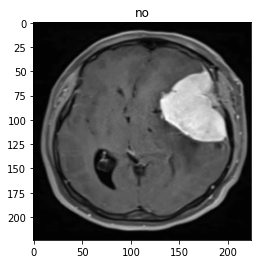

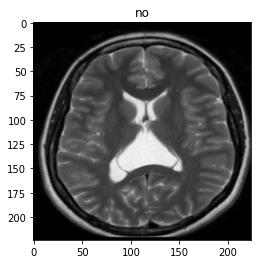

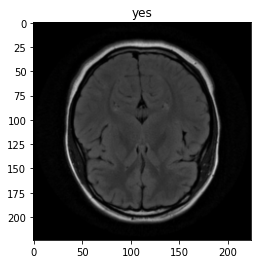

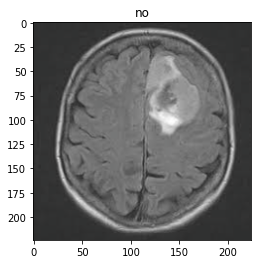

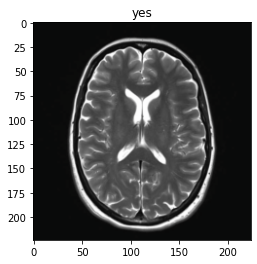

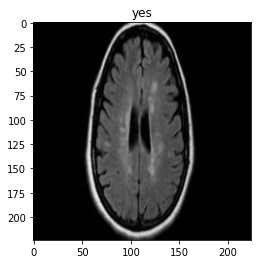

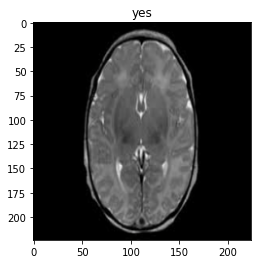

In [68]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [69]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [70]:
model = models.resnet50(pretrained=True)
# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)

In [71]:
print(model.fc.in_features)

2048


In [72]:
train_model(model, loss, optimizer, scheduler, num_epochs=18);

Epoch 0/17:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]

train Loss: 0.6975 Acc: 0.6286




100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

val Loss: 0.4893 Acc: 0.8163
Epoch 1/17:




100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

train Loss: 0.5170 Acc: 0.7143




100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

val Loss: 0.4090 Acc: 0.7959
Epoch 2/17:




100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

train Loss: 0.4144 Acc: 0.8048




100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

val Loss: 0.4148 Acc: 0.7755
Epoch 3/17:




100%|██████████| 30/30 [00:53<00:00,  1.78s/it]

train Loss: 0.4269 Acc: 0.8000




100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

val Loss: 0.2784 Acc: 0.8980
Epoch 4/17:




100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

train Loss: 0.4194 Acc: 0.8381




100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

val Loss: 0.5119 Acc: 0.6939
Epoch 5/17:




100%|██████████| 30/30 [00:56<00:00,  1.89s/it]

train Loss: 0.3901 Acc: 0.8238




100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

val Loss: 0.2617 Acc: 0.9184
Epoch 6/17:




100%|██████████| 30/30 [00:54<00:00,  1.80s/it]

train Loss: 0.3200 Acc: 0.9000




100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

val Loss: 0.2542 Acc: 0.9184
Epoch 7/17:




100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

train Loss: 0.3280 Acc: 0.8905




100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

val Loss: 0.2739 Acc: 0.9184
Epoch 8/17:




100%|██████████| 30/30 [00:54<00:00,  1.80s/it]

train Loss: 0.3349 Acc: 0.8667




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2739 Acc: 0.9184
Epoch 9/17:




100%|██████████| 30/30 [00:54<00:00,  1.82s/it]

train Loss: 0.3281 Acc: 0.8810




100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

val Loss: 0.2644 Acc: 0.9184
Epoch 10/17:




100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

train Loss: 0.3311 Acc: 0.8619




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2654 Acc: 0.8980
Epoch 11/17:




100%|██████████| 30/30 [00:53<00:00,  1.80s/it]

train Loss: 0.3369 Acc: 0.8714




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2740 Acc: 0.9184
Epoch 12/17:




100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

train Loss: 0.3390 Acc: 0.8571




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2612 Acc: 0.9184
Epoch 13/17:




100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

train Loss: 0.2903 Acc: 0.9286




100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

val Loss: 0.2714 Acc: 0.9184
Epoch 14/17:




100%|██████████| 30/30 [00:53<00:00,  1.80s/it]

train Loss: 0.2689 Acc: 0.9190




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2725 Acc: 0.9184
Epoch 15/17:




100%|██████████| 30/30 [00:53<00:00,  1.80s/it]

train Loss: 0.3419 Acc: 0.8667




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2561 Acc: 0.9184
Epoch 16/17:




100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

train Loss: 0.3073 Acc: 0.8905




100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

val Loss: 0.2616 Acc: 0.9184
Epoch 17/17:




100%|██████████| 30/30 [00:54<00:00,  1.81s/it]

train Loss: 0.3244 Acc: 0.8857




100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

val Loss: 0.2791 Acc: 0.9184


In [34]:
!rm -rf train val